In [2]:
cd ..

/home/yann/IVISpaces


In [3]:
from torch import nn

import torch
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import trange

from Metrics.SSGE import SpectralSteinEstimator
from Metrics.KLdivergence import KL
from Tools import NormalLogLikelihood

from torch.distributions import MultivariateNormal

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# beta in NN estimation of KL #
nb_samples= 100

experimentation on multivariate gaussian 

|dimension|beta|
|---|---|
|2|0.95|
|3|0.9|
|4|0.85|
|5| 0.8|
|10|0.7|
|20|0.64|
|30| 0.61|
|40| 0.59|
|50|0.583|
|100|0.56|
|150|0.545|
|200|0.54|
|300|0.53|
|500|0.525|
|1000|0.52|


# Grid search #

In [37]:
n_samples=500
N=151
true_p=1.*torch.ones(N,device=device)
true_q=torch.zeros(N,device=device)
target = MultivariateNormal(true_q,torch.diagflat(true_p))

learning_rate=0.05
patience=25
lr_decay=0.5
min_lr=0.05/8

class MeanField(nn.Module):
    def __init__(self,dim):        
        super(MeanField, self).__init__()
        self.p = torch.nn.Parameter(torch.Tensor(dim))
        self.q = torch.nn.Parameter(torch.Tensor(dim))
        self.dim=dim
        
        torch.nn.init.uniform_(self.p,a=0.1, b=5.)
        torch.nn.init.normal_(self.q,mean=0., std=5.)

    def forward(self,x):
        assert x.shape[1] == self.dim, 'dimension mismatch'
        return self.p*x+self.q

def run(n_samples,N,beta,repeat):
    
    
    params={'p':[],'q':[]}
    for r in range(repeat):
        variational=MeanField(N).to(device) 
        optimizer = torch.optim.Adam(variational.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           patience=patience, 
                                                           factor=lr_decay,
                                                           verbose=False)
        for _ in range(3000):
            optimizer.zero_grad()

            x=torch.randn(n_samples,N).to(device)

            n_samples=x.shape[0]
            sample=variational(x)

            K=KL(sample.view(-1,N),target.sample((n_samples,)),k=1,beta=beta)
            K.backward()

            optimizer.step()

            scheduler.step(K.item())

            if optimizer.param_groups[0]['lr'] <= min_lr:
                break
        params['p'].append(variational.p.data.clone().cpu().numpy())
        params['q'].append(variational.q.data.clone().cpu().numpy())
    return {beta:params}


def meanlogKNNdistance(p,q,k):
    x=torch.randn(n_samples,p.shape[0]).to(p.device)
    sample=p*x+q
    distances= torch.cdist(sample, sample, p=2)
    kNN = torch.topk(distances, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf
    return kNN.log().mean()
true_meankNN=meanlogKNNdistance(true_p,true_q,k=1)
print(true_meankNN)

tensor(2.6886, device='cuda:0')


In [29]:
betas=torch.linspace(0.1,1.,20).numpy()
params={'beta':betas}

In [30]:
import pandas as pd

results={}
for i in trange(len(betas)):
    results.update(run(n_samples,N,betas[i],10))

        

100%|██████████| 20/20 [03:46<00:00, 11.32s/it]


In [31]:
frame=pd.DataFrame(results).T
frame

,p,q
0.100000,"[[0.24500905, -0.28656283, 0.37925953, -0.3007...","[[0.124086246, -0.03490995, -0.7485944, 0.0601..."
0.147368,"[[0.38597113, 0.47018325, 0.40582278, 0.393737...","[[-0.029641524, 0.057839975, -0.09137216, -0.1..."
0.194737,"[[0.46661726, 0.40538657, 0.4914628, 0.498222,...","[[0.12685046, -0.080772966, 0.10547446, 0.0695..."
0.242105,"[[0.5640105, 0.5667021, 0.5546692, 0.5031443, ...","[[-0.016365407, -0.030915847, 0.0006196034, -0..."
0.289474,"[[0.56609166, 0.5957468, 0.5713195, 0.61101127...","[[-0.044217896, 0.023469893, 0.031948786, 0.02..."
0.336842,"[[0.64050794, 0.63090193, 0.6578229, 0.6539200...","[[0.014497279, -0.03040403, 0.03190454, -0.034..."
0.384210,"[[0.7805557, 0.7298221, 0.72097105, 0.7220468,...","[[0.008480121, 0.0014149327, 0.014050237, -0.0..."
0.431579,"[[0.7866025, 0.8018998, 0.771992, 0.82509875, ...","[[0.01260517, 0.017530734, -0.0189053, 0.00483..."
0.478947,"[[0.8950107, 0.8886342, 0.81821305, 0.87975144...","[[-0.0005792646, -0.017022856, 0.039210565, -0..."
0.526316,"[[0.9563053, 0.9067058, 0.97999954, 0.9172024,...","[[-0.003575628, -0.012159646, 0.027695417, 0.0..."


In [32]:
import numpy as np
columns=list(betas)

results_errors=[]
for i in range(len(betas)):
    print("{}/{}".format(i+1,len(betas)))
    ps=frame['p'][betas[i]]
    qs=frame['q'][betas[i]]
    for j in range(len(ps)): 
        posterior=MultivariateNormal(torch.as_tensor(qs[j]).to(device),torch.diagflat(torch.as_tensor(ps[j]).abs()).to(device))
        kls_to=torch.distributions.kl.kl_divergence(posterior,target).item()
        kls_from=torch.distributions.kl.kl_divergence(target,posterior).item()
        q_errors=(torch.as_tensor(qs[j]).to(device) -true_q).norm().square().item()
        p_errors=(torch.as_tensor(ps[j]).to(device) -true_p).norm().square().item()
        meanNNd=meanlogKNNdistance(torch.as_tensor(ps[j]).to(device),torch.as_tensor(qs[j]).to(device),1)-true_meankNN
        results_errors.append({'beta':np.round(betas[i],2),'KL_to': kls_to,'KL_from': kls_from, 'p_errors': p_errors, 'q_errors': q_errors, 'meankNNdist':meanNNd.item()})
   # results[betas[i]].update({'KL_from': kls_from})
   # results[betas[i]].update({'p_errors': p_errors})
   # results[betas[i]].update({'q_errors': q_errors})

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


In [33]:
columns=['beta','KL_to','KL_from', 'p_errors', 'q_errors','meankNNdist']
errors=pd.DataFrame(results_errors, columns=columns)
errors.sort_values(['p_errors'], ascending=False)

,beta,KL_to,KL_from,p_errors,q_errors,meankNNdist
192,1.00,320.032867,84.270424,5117.053711,51.082325,1.924901
197,1.00,288.760559,79.709808,4596.711914,27.488874,1.872180
198,1.00,278.212524,78.108719,4429.534668,19.333008,1.856091
190,1.00,283.436279,78.942581,4382.546875,33.550377,1.857120
193,1.00,274.838623,77.584213,4369.793945,17.245495,1.857053
...,...,...,...,...,...,...
103,0.57,0.137955,0.132614,0.344448,0.110976,0.032783
108,0.57,0.139137,0.133820,0.338586,0.116235,0.036696
102,0.57,0.140776,0.135309,0.308815,0.133776,0.040175
100,0.57,0.127320,0.123207,0.294975,0.112936,0.037324


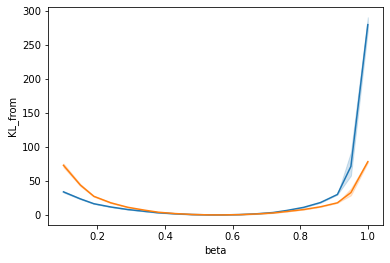

In [34]:
import seaborn as sns
ax=sns.lineplot('beta','KL_to', data=errors)
ax=sns.lineplot('beta','KL_from', data=errors)

#plt.xticks(betas)
#xlabels = np.round(betas,2)#[str(np.round(x*betas.max()/len(betas),2))  for x in ax.get_xticks()]
#ax.set_xticklabels(xlabels)


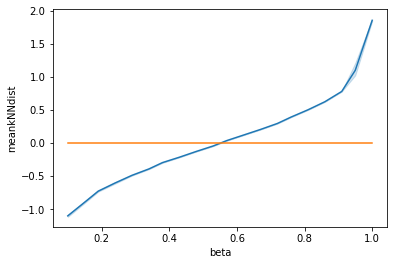

In [35]:
ax=sns.lineplot('beta','meankNNdist', data=errors)
plt.plot(betas,torch.zeros(len(betas)))



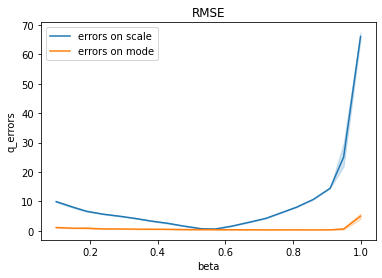

In [36]:

ax=sns.lineplot('beta',np.sqrt(errors['p_errors']), data=errors, label='errors on scale')
ax=sns.lineplot('beta',np.sqrt(errors['q_errors']), data=errors, label='errors on mode')

plt.title('RMSE')
plt.show()

# SSGE #

In [34]:

from Metrics.SSGE import SpectralSteinEstimator

n_samples=500
N=151
true_p=1.*torch.ones(N,device=device)
true_q=torch.zeros(N,device=device)
target = MultivariateNormal(true_q,torch.diagflat(true_p))

lr=0.05
patience=25
lr_decay=0.5
min_lr=0.05/8

class MeanField(nn.Module):
    def __init__(self,dim):        
        super(MeanField, self).__init__()
        self.p = torch.nn.Parameter(torch.Tensor(dim))
        self.q = torch.nn.Parameter(torch.Tensor(dim))
        self.dim=dim
        
        torch.nn.init.uniform_(self.p,a=0.1, b=5.)
        torch.nn.init.normal_(self.q,mean=0., std=5.)

    def forward(self,x):
        assert x.shape[1] == self.dim, 'dimension mismatch'
        return self.p*x+self.q

etas=torch.linspace(0.1,1.,10).numpy()
    
    
def run(eta):
    variational=MeanField(N).to(device) 
    for _ in range(2000):
        x=torch.randn(n_samples,N).to(device)
        sample=variational(x)

        lp=-target.log_prob(sample).mean()
        lp_grad_p=torch.autograd.grad(lp,variational.p,retain_graph=True)[0]
        lp_grad_q=torch.autograd.grad(lp,variational.q,retain_graph=True)[0]


        # Get the estimate of the score 
        score_estimator = SpectralSteinEstimator(eta=eta)
        score = score_estimator(sample,sample)

        #compute gradients with respect to parameters
        H_grad_p = torch.autograd.grad(sample, variational.p,
                              grad_outputs=score,
                              retain_graph=True)[0]/n_samples
        H_grad_q = torch.autograd.grad(sample, variational.q,
                              grad_outputs=score,
                              retain_graph=True)[0]/n_samples

        variational.p.data.add_(-lr*(H_grad_p+lp_grad_p))
        variational.q.data.add_(-lr*(H_grad_q+lp_grad_q))


    posterior=MultivariateNormal(variational.q.detach(),torch.diagflat(variational.p.detach()))
    kls_to=torch.distributions.kl.kl_divergence(posterior,target).item()
    kls_from=torch.distributions.kl.kl_divergence(target,posterior).item()
    q_errors=(variational.q.detach() -true_q).norm().square().item()
    p_errors=(variational.p.detach() -true_p).norm().square().item()
    results_errors={'KL_to': kls_to,'KL_from': kls_from, 'p_errors': p_errors, 'q_errors': q_errors}
    return results_errors

In [36]:
gs_results=[]
repeat=5
#for i in range(len(etas)):
for r in trange(repeat):
    print('sigma({}):{}/{}'.format(i,r+1,repeat))
    gs_results.append(run(0.0))

  0%|          | 0/5 [00:00<?, ?it/s]

sigma(0):1/5


 20%|██        | 1/5 [05:56<23:44, 356.09s/it]

sigma(0):2/5


 40%|████      | 2/5 [11:49<17:46, 355.37s/it]

sigma(0):3/5


 60%|██████    | 3/5 [17:40<11:48, 354.04s/it]

sigma(0):4/5


 80%|████████  | 4/5 [23:35<05:54, 354.28s/it]

sigma(0):5/5


100%|██████████| 5/5 [29:31<00:00, 354.28s/it]


In [ ]:
errors=pd.DataFrame(gs_results)